In [210]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tools.eval_measures import mse
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_predict

In [211]:
df_MSFT = pd.read_csv("./dataset_MSFT_Stock/MSFT_Stock.csv", index_col=0)

In [212]:
df_MSFT.index = pd.to_datetime(df_MSFT.index)
df_MSFT.head()

,open,high,low,close,volume
2001-03-16,26.25000,27.56250,26.24219,27.28125,112848800
2001-03-19,27.25000,27.75000,26.56250,27.15625,61036400
2001-03-20,27.28125,28.06250,26.31250,26.34375,91822800
2001-03-21,26.12500,26.62500,24.87500,25.03125,124988600
2001-03-22,25.28125,27.03125,25.25000,27.00000,126363200


In [213]:
# examine shape of dataframe, variable types
print(df_MSFT.shape)
print(df_MSFT.dtypes)

(5000, 5)
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object


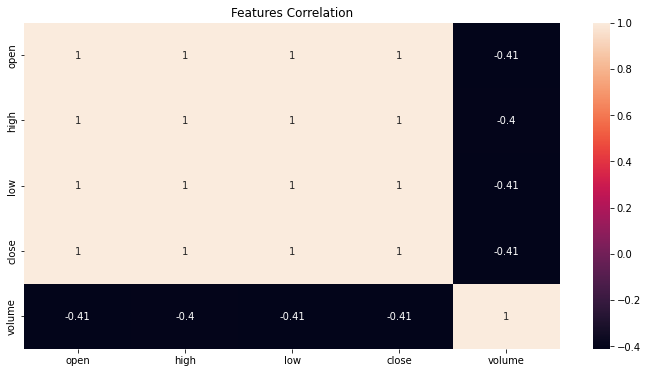

In [214]:
# plotting and displaying corrlation of features with values
plt.figure(figsize=(12,6))
sns.heatmap(
    df_MSFT.corr(), 
    annot=True,
    )
plt.title('Features Correlation');

C:\Users\mat98\AppData\Local\Temp\ipykernel_33004\1303468666.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df_MSFT = df_MSFT.dropna('columns')


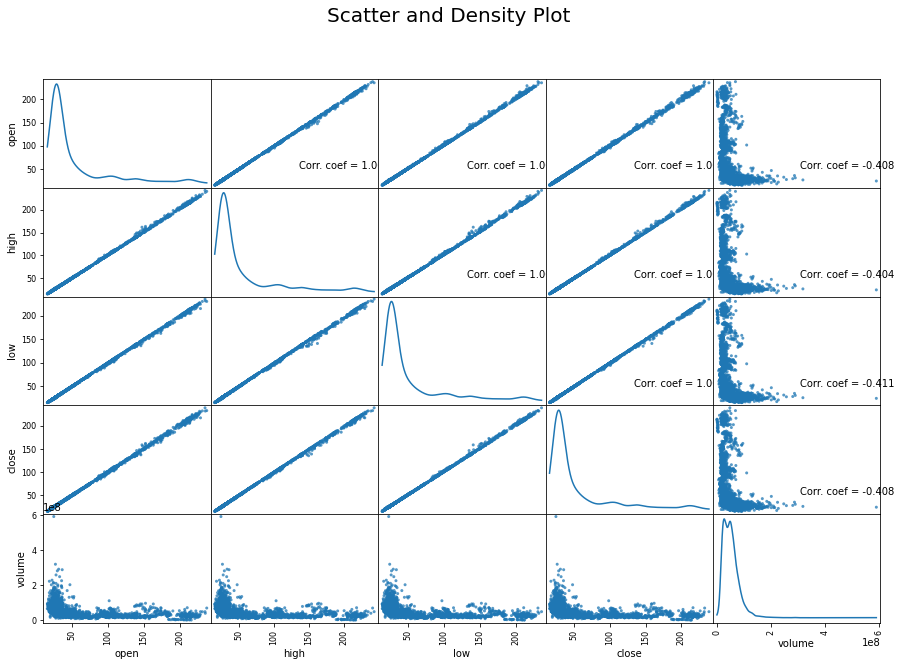

In [215]:
df_MSFT = df_MSFT.select_dtypes(include =[np.number]) # keep only numerical columns
# Remove rows and columns that would lead to df_MSFT being singular
df_MSFT = df_MSFT.dropna('columns')
df_MSFT = df_MSFT[[col for col in df_MSFT if df_MSFT[col].nunique() > 1]] # keep columns where there are more than 1 unique values
columnNames = list(df_MSFT)
if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
    columnNames = columnNames[:10]
df_MSFT = df_MSFT[columnNames]
ax = pd.plotting.scatter_matrix(df_MSFT, alpha=0.75, figsize=[15, 10], diagonal='kde')
corrs = df_MSFT.corr().values
for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
    ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=10)
plt.suptitle('Scatter and Density Plot', size=20)
plt.show()

In [216]:
# creating for loop to print the minimum stock price for each feature and number of stocks with date
for col in df_MSFT.columns:
    min_val = df_MSFT[col].min()
    print(df_MSFT[df_MSFT[col] == df_MSFT[col].min()][col])
    print()

2009-03-09    15.2
Name: open, dtype: float64

2009-03-06    15.62
Name: high, dtype: float64

2009-03-06    14.87
Name: low, dtype: float64

2009-03-09    15.15
Name: close, dtype: float64

2020-07-08    1123154
Name: volume, dtype: int64



In [217]:
# creating for loop to print the minimum stock price for each feature and number of stocks with date
for col in df_MSFT.columns:
    max_val = df_MSFT[col].max()
    print(df_MSFT[df_MSFT[col] == df_MSFT[col].max()][col])
    print()

2021-01-27    238.0
Name: open, dtype: float64

2021-01-28    242.64
Name: high, dtype: float64

2021-01-28    235.09
Name: low, dtype: float64

2021-01-28    238.92999
Name: close, dtype: float64

2006-04-28    591052200
Name: volume, dtype: int64



C:\Users\mat98\AppData\Local\Temp\ipykernel_33004\3116011515.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=20)
C:\Users\mat98\AppData\Local\Temp\ipykernel_33004\3116011515.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=20)
C:\Users\mat98\AppData\Local\Temp\ipykernel_33004\3116011515.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=20)
C:\Users\mat98\AppData\Local\Temp\ipykernel_33004\3116011515.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=20)


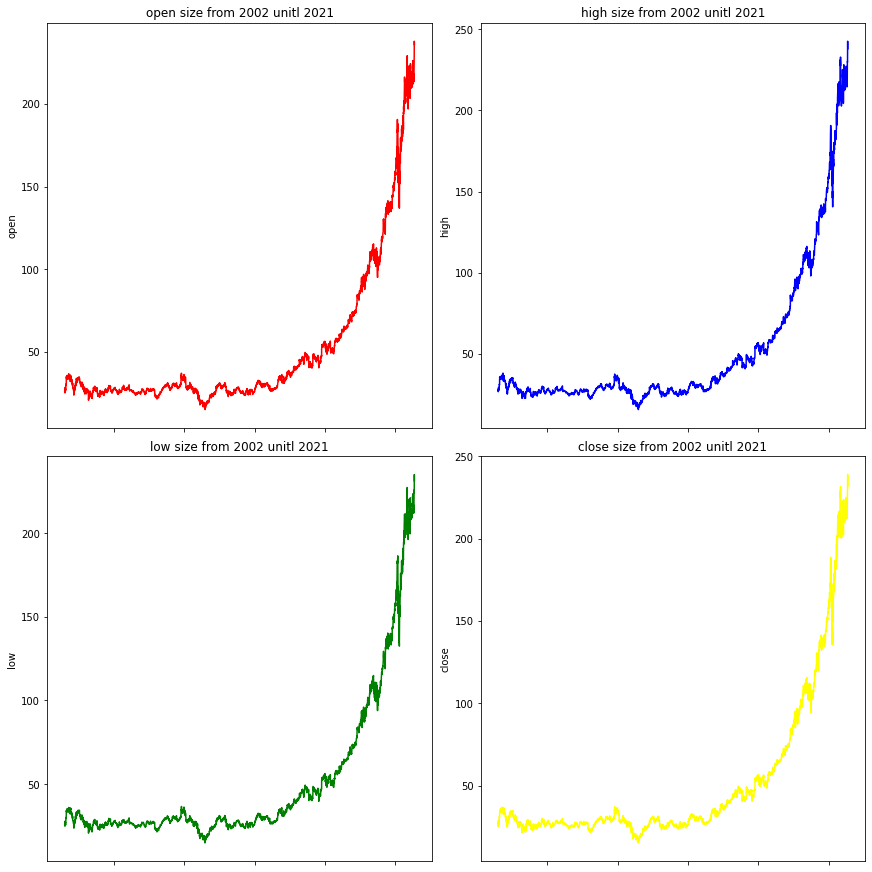

In [218]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 12), constrained_layout=True) 
ax = ax.ravel()

colors = ['red', 'blue', 'green', 'yellow']
cols = [col for col in df_MSFT.columns if col != 'volume']

for i in range(len(cols)):
    df_MSFT.iloc[:,i].plot(ax=ax[i], color=colors[i], )
    ax[i].set(ylabel=cols[i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=20)
    ax[i].set_title(f'{cols[i]} size from 2002 unitl 2021');

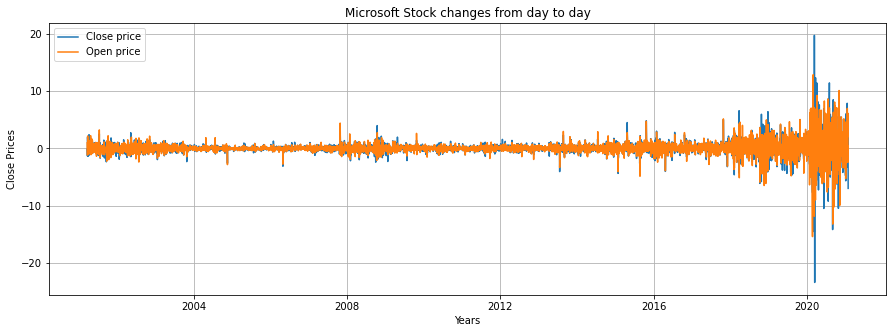

In [219]:
# the difference between day to day
#plot close price
plt.figure(figsize=(15,5))
plt.grid(True)
plt.xlabel('Years')
plt.ylabel('Close Prices')
plt.plot(df_MSFT.diff()[['close','open']])
plt.title('Microsoft Stock changes from day to day')
plt.legend( ["Close price", "Open price"])
plt.show()

In [220]:
# resampling to 4 Quarter (season)
df_MSFT.resample('Q').mean().head()

,open,high,low,close,volume
2001-03-31,27.318182,28.110795,26.732245,27.369318,9.379107e+07
2001-06-30,33.737738,34.345417,33.266349,33.851210,8.416334e+07
2001-09-30,31.315593,31.806186,30.747881,31.238390,6.982918e+07
2001-12-31,31.392891,31.971875,30.956172,31.523672,6.342107e+07
2002-03-31,31.497250,31.930833,31.067083,31.466250,5.940865e+07


In [221]:
new_df = df_MSFT.resample('Q').mean()[['close']]

new_df.head()

,close
2001-03-31,27.369318
2001-06-30,33.851210
2001-09-30,31.238390
2001-12-31,31.523672
2002-03-31,31.466250


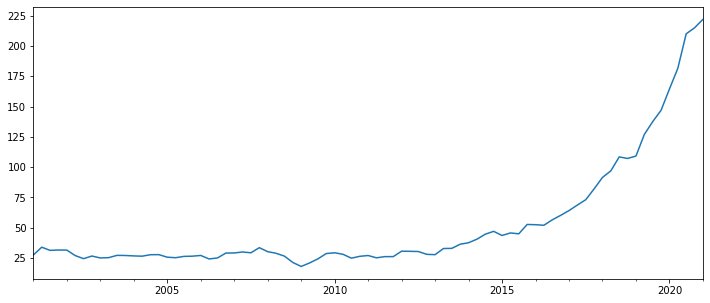

In [222]:
new_df['close'].plot(figsize=(12, 5))
plt.show()

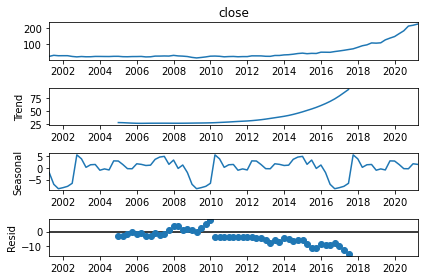

In [223]:
#Do Time Series Decomposition to check for Seasonality
result = seasonal_decompose(new_df['close'],period=30)
result.plot();

In [224]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [225]:
def autocorr_plots(y, lags=None):
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
    plot_acf(y, lags=lags, ax=ax[0])
    plot_pacf(y, lags=lags, ax=ax[1])
    return fig, ax

In [226]:
adf_test(new_df['close'])

Augmented Dickey-Fuller Test: 
ADF test statistic       3.401597
p-value                  1.000000
# lags used             12.000000
# observations          68.000000
critical value (1%)     -3.530399
critical value (5%)     -2.905087
critical value (10%)    -2.590001
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [227]:
#our data is not stationary
# 2. Do differencing until we make our data stationary
# d = 1
adf_test(new_df['close'].diff().dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic       2.566388
p-value                  0.999068
# lags used             11.000000
# observations          68.000000
critical value (1%)     -3.530399
critical value (5%)     -2.905087
critical value (10%)    -2.590001
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [228]:
# d = 2
adf_test(new_df['close'].diff().diff().dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.083575
p-value                  0.251170
# lags used             10.000000
# observations          68.000000
critical value (1%)     -3.530399
critical value (5%)     -2.905087
critical value (10%)    -2.590001
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [229]:
# d = 3
adf_test(new_df['close'].diff().diff().diff().dropna())

#After three times of differenced our data get a stationary

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.693564e+00
p-value                 1.398445e-11
# lags used             9.000000e+00
# observations          6.800000e+01
critical value (1%)    -3.530399e+00
critical value (5%)    -2.905087e+00
critical value (10%)   -2.590001e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


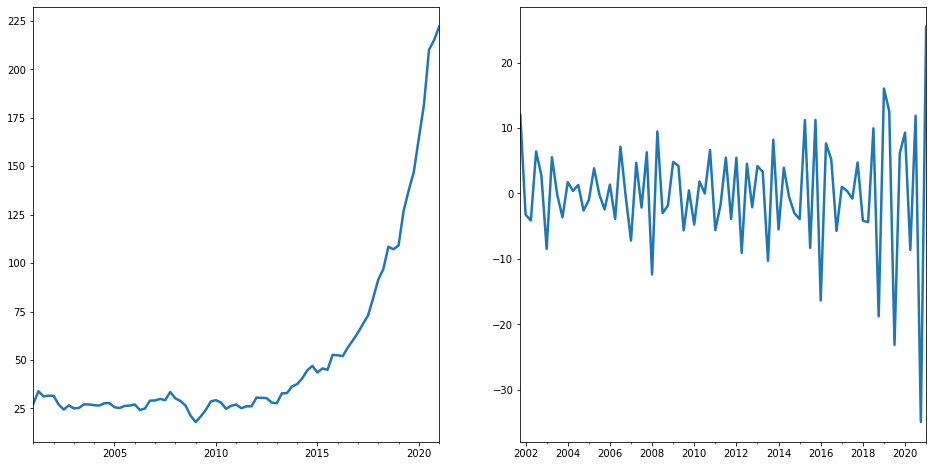

In [230]:
fig,ax=plt.subplots(ncols=2,figsize=(16,8))

new_df['close'].plot(lw=2.5, ax=ax[0])
new_df['close'].diff().diff().diff().dropna().plot(lw=2.5, ax=ax[1]);

c:\Users\mat98\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


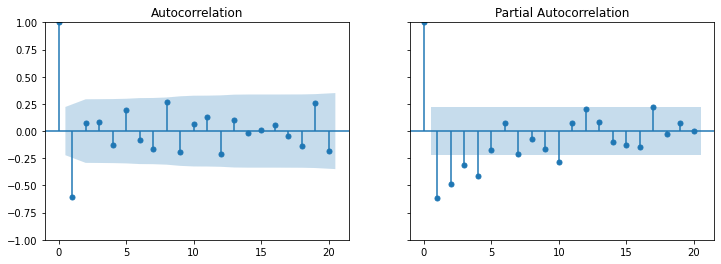

In [231]:
#Determine the p and q values (Manually)
#3. Create ACF and PACF plots on our differenced data
autocorr_plots(new_df['close'].diff().diff().diff().dropna(), lags=20);

In [232]:
auto_fit = auto_arima(new_df['close'], start_p=0, start_q=0,
                          max_p=2, max_q=2, 
                          m=1,                     # m is used for seasonality, m=1 means no seasonality (cover this later)
                          seasonal=False,          # We do not want seasonality here
                          d=None,  # The order of first-differencing. If None (by default), automatically be selected
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

auto_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=487.042, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=473.634, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=456.285, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=485.042, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=458.024, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=457.967, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=459.197, Time=0.30 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=456.390, Time=0.07 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0] intercept
Total fit time: 1.078 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   81
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -225.143
Date:                Fri, 30 Dec 2022   AIC                            456.285
Time:                        17:36:49   BIC                            463.394
Sample:                    03-31-2001   HQIC                           459.133
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1582      0.121      1.311      0.190      -0.078       0.395
ma.L1         -0.8047      0.040    -20.075      0.000      -0.883      -0.726
sigma2        17.2659      1.941      8.897      0.000      13.462      21.070
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                40.36
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               5.99   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [233]:
#What was the values of (p,d,q) suggested by auto-arima?
#As you can see the output of the summery, is suggests ARIMA(2,1,1) as the best based on AIC/BIC lowest values

#5. Fit ARIMA model
#Train/Test Split
# See what are the ranges of our data
new_df.index.max(), new_df.index.min()

(Timestamp('2021-03-31 00:00:00', freq='Q-DEC'),
 Timestamp('2001-03-31 00:00:00', freq='Q-DEC'))

In [234]:
df_train = new_df.loc[:'2019']
df_test = new_df.loc['2019':]

In [235]:
df_train.shape

(76, 1)

In [236]:
df_test.shape

(9, 1)

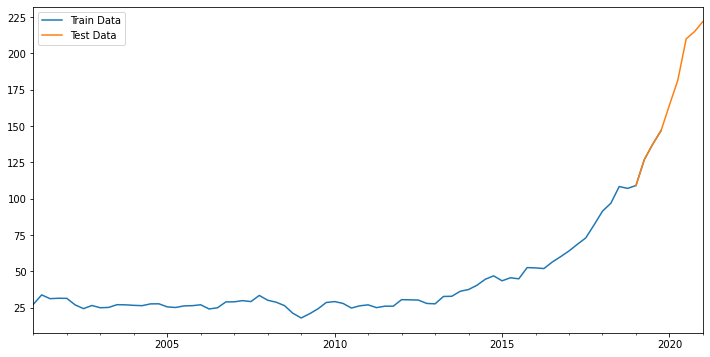

In [237]:
# Plot the train and test sets on the axis ax
fig, ax = plt.subplots(figsize=(12,6))
df_train.plot(ax=ax)
df_test.plot(ax=ax)
ax.legend(labels=['Train Data','Test Data']);

In [238]:
#Fitting ARIMA models

model = ARIMA(df_train,order=(2,1,1))
res = model.fit()
res.summary()

c:\Users\mat98\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\mat98\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                   76
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -198.558
Date:                Fri, 30 Dec 2022   AIC                            405.116
Time:                        17:36:52   BIC                            414.386
Sample:                    03-31-2001   HQIC                           408.817
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0273      0.191      5.374      0.000       0.653       1.402
ar.L2         -0.0375      0.183     -0.205      0.837      -0.396       0.321
ma.L1         -0.8087      0.126     -6.400      0.000      -1.056      -0.561
sigma2        11.4059      1.605      7.107      0.000       8.260      14.551
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.94
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.61   Skew:                             0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

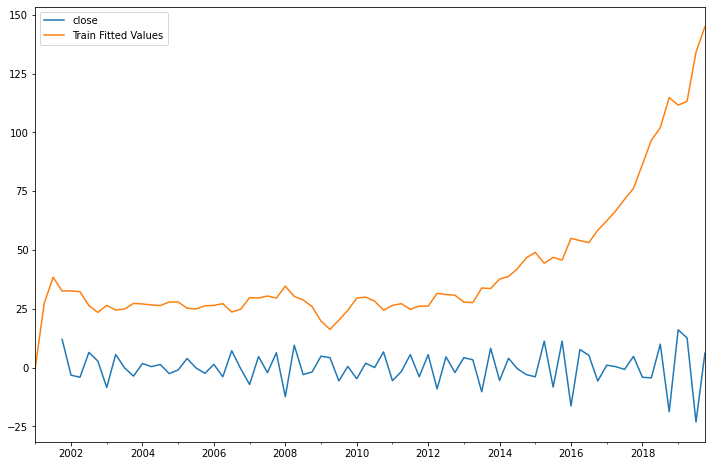

In [239]:
# plot our fitted values for train data

df_train.diff().diff().diff().dropna().plot(legend = True,figsize=(12,8))
res.fittedvalues.rename("Train Fitted Values").plot(legend = True)
plt.show()

In [240]:
#Predict values on the test dataset
# plot our prediction for test data


start = len(df_train) 
end = len(df_train) + len(df_test) -1
  
# Predictions for the test set 

# Notice below typ='level' , it will predict the levels of the original variables (undifferenced)
predictions = res.predict(start, end,typ ='levels',dynamic=False) # .rename("Test predicted")  

In [241]:
predictions

2020-03-31    154.554228
2020-06-30    162.059524
2020-09-30    169.482886
2020-12-31    176.827462
2021-03-31    184.094172
2021-06-30    191.283846
2021-09-30    198.397299
2021-12-31    205.435341
2022-03-31    212.398770
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [242]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<4.4}, expected={df_test['close'][i]}")

predicted=154.6, expected=109.10295081967213
predicted=162.1, expected=126.95539682539682
predicted=169.5, expected=137.51328109375
predicted=176.8, expected=146.90547
predicted=184.1, expected=164.44903258064517
predicted=191.3, expected=181.52395222222222
predicted=198.4, expected=210.030153125
predicted=205.4, expected=215.0101553125
predicted=212.4, expected=221.97526105263157


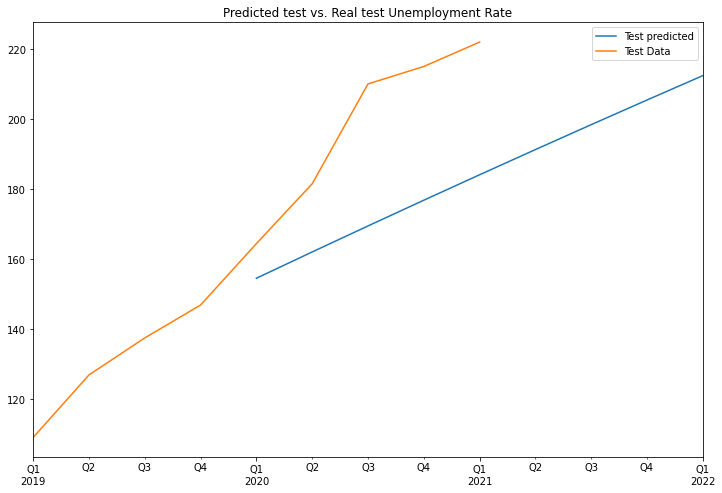

In [243]:
# plot predictions and actual test values 
title = 'Predicted test vs. Real test Unemployment Rate'
ax=predictions.plot(legend = True,figsize=(12,8),title=title) 
df_test.plot(legend = True,ax=ax);
ax.legend(labels=['Test predicted','Test Data']);

In [244]:
#Evaluate the Model

error1 = mse(df_test['close'], predictions)
print(f'ARIMA(2,1,1) MSE Error: {error1:11.10}')

error2 = rmse(df_test['close'], predictions)
print(f'ARIMA(2,1,1) RMSE Error: {error2:11.10}')

ARIMA(2,1,1) MSE Error: 668.3773521
ARIMA(2,1,1) RMSE Error: 25.85299503


In [245]:
new_df['close'].mean()

52.083901584824545

In [246]:
#6. Forcast the Future
# Do a forcast for 1 Quarter (3 months) (2021Q1 to 2021Q2)
fcast = res.predict(start=len(df_test),end=len(df_test)+1,typ='levels',dynamic=False).rename('ARIMA(2,1,1) Forecast')

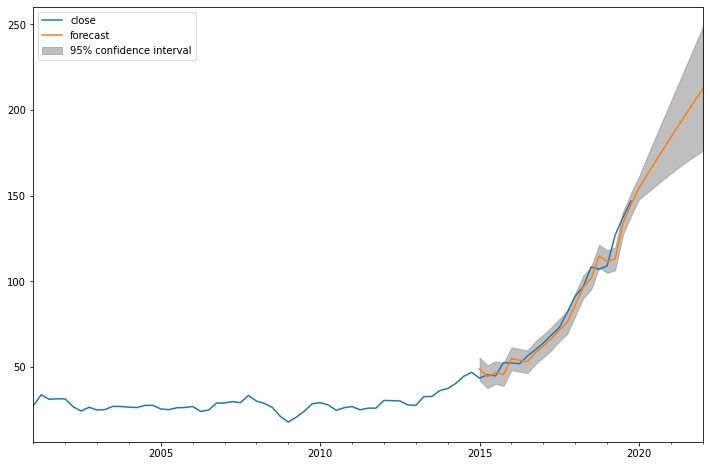

In [247]:
# starting and end points for forecasting for our previous model

fig, ax = plt.subplots(figsize=(12,8)) 
ax = df_train.loc['2001':].plot(ax=ax)
plot_predict(res, '2015', '2022', ax =ax,)
plt.legend(loc=2)